In [1]:
!pip install -q transformers accelerate bitsandbytes scipy
!pip -q install evaluate
!pip -q install bert_score

In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [44]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import warnings
import evaluate
warnings.filterwarnings('ignore')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
data = pd.read_csv('../../../data/yelp/test_en_parallel.txt', sep='\t', header=None, skiprows=1)
data.columns = ['NEG', 'POS']

In [6]:
print("Pairs:", len(data))
print(data.head())

Pairs: 1000
                                                 NEG  \
0  ever since joes has changed hands it's just go...   
1  there is definitely not enough room in that pa...   
2                  so basically tasted watered down.   
3  she said she'd be back and disappeared for a f...   
4  i can't believe how inconsiderate this pharmac...   

                                                 POS  
0  Ever since joes has changed hands it's gotten ...  
1    There is so much room in that part of the venue  
2              It didn't taste watered down at all.   
3  She said she'd be back, and didn't disappear a...  
4               This pharmacy is really considerate.  


In [7]:
train_df, test_df = train_test_split(
    data,
    test_size=0.2,
    random_state=42
)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train pairs:", len(train_df), "Test pairs:", len(test_df))

Train pairs: 800 Test pairs: 200


In [8]:
model_name = 'meta-llama/Llama-2-7b-chat-hf'

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map='auto',
    trust_remote_code=True
)
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMS

In [31]:
np.random.seed(42)

def create_few_shot_prompt_rewrite_to_positive(neg_sentence, n_shots, train_df):

    if n_shots == 0:
        return f"""Rewrite the following sentence to express a POSITIVE sentiment while preserving the original meaning.
        Only output the rewritten sentence, nothing else.

        NEGATIVE: {neg_sentence}
        POSITIVE:"""

    prompt = (
        "Rewrite the following sentence to express a POSITIVE sentiment while preserving the original meaning. "
        # "Use the positive example/s from the training set to guide you."
        "Only output the rewritten sentence, nothing else.\n\n"
    )

    n = min(n_shots, len(train_df))
    shot_indices = np.random.choice(len(train_df), size=n, replace=False)

    for idx in shot_indices:
        neg_ex = train_df.loc[idx, 'NEG']
        pos_ex = train_df.loc[idx, 'POS']
        prompt += (f"NEGATIVE: {neg_ex}\n"
                   f"POSITIVE: {pos_ex}\n\n")

    prompt += (f"NEGATIVE: {neg_sentence}\n"
               f"POSITIVE:")
    return prompt

In [15]:
def generate_positive(prompt, max_new_tokens=64):
    inputs = tokenizer(
        prompt,
        return_tensors='pt',
        truncation=True,
        max_length=2048
    )
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            do_sample=True,
            top_p=0.9,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

    text = decoded.split("POSITIVE:")[-1].strip()

    text = re.sub(r'^\s*["“”]', '', text)
    text = text.split("\n")[0].strip()

    return text

In [11]:
bleu = evaluate.load("bleu")
bertscore = evaluate.load("bertscore")

In [27]:
n_shot_values = [0]
results = []

NEG_test = test_df['NEG'].tolist()
POS_ref  = test_df['POS'].tolist()

In [28]:
for n_shots in n_shot_values:
    print(f"n={n_shots}")
    np.random.seed(42)

    predictions = []

    for i, neg_sent in enumerate(tqdm(NEG_test, desc=f"{n_shots}-shot")):
        prompt = create_few_shot_prompt_rewrite_to_positive(neg_sent, n_shots, train_df)
        pos_hat = generate_positive(prompt)

        # To avoid empty generated outputs
        if pos_hat is None or pos_hat.strip() == "":
            pos_hat = "The experience was positive."

        predictions.append(pos_hat)

        if i % 50 == 0:
            print("\nSample", i)
            print("Negative:", neg_sent[:80])
            print("Positive:", POS_ref[i][:80])
            print("Generated:", pos_hat[:80])

    bleu_score = bleu.compute(predictions=predictions, references=[[r] for r in POS_ref])["bleu"]
    bs = bertscore.compute(predictions=predictions, references=POS_ref, lang="en")
    bert_f1 = float(np.mean(bs["f1"]))

    results.append({
        "n_shots": n_shots,
        "bleu": bleu_score,
        "bertscore_f1": bert_f1
    })

    print(f"BLEU: {bleu_score:.4f}")
    print(f"BERTScore F1: {bert_f1:.4f}")


n=0


0-shot:   0%|          | 1/200 [00:00<03:10,  1.05it/s]


Sample 0
Negative: Every experience has been awful.
Positive: and every experience has been a positive one.
Generated: Every experience has been amazing.


0-shot:  26%|██▌       | 51/200 [01:00<04:41,  1.89s/it]


Sample 50
Negative: it is consistently bad and the staff is always rude
Positive: it is consistent and the staff is always friendly.
Generated: it is consistently great and the staff is always friendly


0-shot:  50%|█████     | 101/200 [01:58<02:05,  1.26s/it]


Sample 100
Negative: busy place and had to wait an hour to get my food
Positive: the place was busy but the service was excellent!
Generated: bustling with activity and got my food in no time


0-shot:  76%|███████▌  | 151/200 [03:11<01:13,  1.50s/it]


Sample 150
Negative: everything we've ever ordered her has been horrible tasting
Positive: everything we've ever ordered here has been great tasting.
Generated: everything we've ever ordered from her has been absolutely delicious!


0-shot: 100%|██████████| 200/200 [04:14<00:00,  1.27s/it]


BLEU: 0.1939
BERTScore F1: 0.9156


*I split it here between 0 and more than 0 shots because I tested different prompts for more than 0 shots runs*

In [32]:
n_shot_values = [1, 5, 10]

for n_shots in n_shot_values:
    print(f"n={n_shots}")
    np.random.seed(42)

    predictions = []

    for i, neg_sent in enumerate(tqdm(NEG_test, desc=f"{n_shots}-shot")):
        prompt = create_few_shot_prompt_rewrite_to_positive(neg_sent, n_shots, train_df)
        pos_hat = generate_positive(prompt)

        if pos_hat is None or pos_hat.strip() == "":
            pos_hat = "The experience was positive."

        predictions.append(pos_hat)

        if i % 50 == 0:
            print("\nSample", i)
            print("Negative:", neg_sent[:80])
            print("Positive:", POS_ref[i][:80])
            print("Generated:", pos_hat[:80])

    bleu_score = bleu.compute(predictions=predictions, references=[[r] for r in POS_ref])["bleu"]
    bs = bertscore.compute(predictions=predictions, references=POS_ref, lang="en")
    bert_f1 = float(np.mean(bs["f1"]))

    results.append({
        "n_shots": n_shots,
        "bleu": bleu_score,
        "bertscore_f1": bert_f1
    })

    print(f"BLEU: {bleu_score:.4f}")
    print(f"BERTScore F1: {bert_f1:.4f}")


n=1


1-shot:   0%|          | 1/200 [00:05<16:48,  5.07s/it]


Sample 0
Negative: Every experience has been awful.
Positive: and every experience has been a positive one.
Generated: This product is of exceptional quality.


1-shot:  26%|██▌       | 51/200 [01:32<02:58,  1.20s/it]


Sample 50
Negative: it is consistently bad and the staff is always rude
Positive: it is consistent and the staff is always friendly.
Generated: the restaurant has a consistent quality and the staff is friendly


1-shot:  50%|█████     | 101/200 [03:13<03:04,  1.87s/it]


Sample 100
Negative: busy place and had to wait an hour to get my food
Positive: the place was busy but the service was excellent!
Generated: I enjoyed a leisurely meal at a bustling restaurant.


1-shot:  76%|███████▌  | 151/200 [05:29<02:43,  3.33s/it]


Sample 150
Negative: everything we've ever ordered her has been horrible tasting
Positive: everything we've ever ordered here has been great tasting.
Generated: the hotel


1-shot: 100%|██████████| 200/200 [07:39<00:00,  2.30s/it]


BLEU: 0.0976
BERTScore F1: 0.8907
n=5


5-shot:   0%|          | 1/200 [00:00<02:14,  1.47it/s]


Sample 0
Negative: Every experience has been awful.
Positive: and every experience has been a positive one.
Generated: Every experience has been amazing!


5-shot:  26%|██▌       | 51/200 [02:30<09:36,  3.87s/it]


Sample 50
Negative: it is consistently bad and the staff is always rude
Positive: it is consistent and the staff is always friendly.
Generated: the movie was fantastic and the acting was superb.


5-shot:  50%|█████     | 101/200 [04:56<06:01,  3.66s/it]


Sample 100
Negative: busy place and had to wait an hour to get my food
Positive: the place was busy but the service was excellent!
Generated: i love this class and the teacher!


5-shot:  76%|███████▌  | 151/200 [07:42<02:52,  3.52s/it]


Sample 150
Negative: everything we've ever ordered her has been horrible tasting
Positive: everything we've ever ordered here has been great tasting.
Generated: every dish we've tried here has been absolutely delicious.


5-shot: 100%|██████████| 200/200 [10:32<00:00,  3.16s/it]


BLEU: 0.0835
BERTScore F1: 0.8819
n=10


10-shot:   0%|          | 1/200 [00:00<02:09,  1.53it/s]


Sample 0
Negative: Every experience has been awful.
Positive: and every experience has been a positive one.
Generated: Every experience has been wonderful!


10-shot:  26%|██▌       | 51/200 [03:13<10:47,  4.35s/it]


Sample 50
Negative: it is consistently bad and the staff is always rude
Positive: it is consistent and the staff is always friendly.
Generated: the movie was fascinating and unpredictable.


10-shot:  50%|█████     | 101/200 [06:32<08:14,  4.99s/it]


Sample 100
Negative: busy place and had to wait an hour to get my food
Positive: the place was busy but the service was excellent!
Generated: i


10-shot:  76%|███████▌  | 151/200 [09:42<03:39,  4.47s/it]


Sample 150
Negative: everything we've ever ordered her has been horrible tasting
Positive: everything we've ever ordered here has been great tasting.
Generated: our favorite dish is their special of the day!


10-shot: 100%|██████████| 200/200 [13:10<00:00,  3.95s/it]


BLEU: 0.0519
BERTScore F1: 0.8709


In [33]:
results_df = pd.DataFrame(results)
print("\n", results_df.to_string(index=False))


  n_shots     bleu  bertscore_f1
       0 0.193885      0.915629
       1 0.097555      0.890668
       5 0.083526      0.881919
      10 0.051910      0.870858


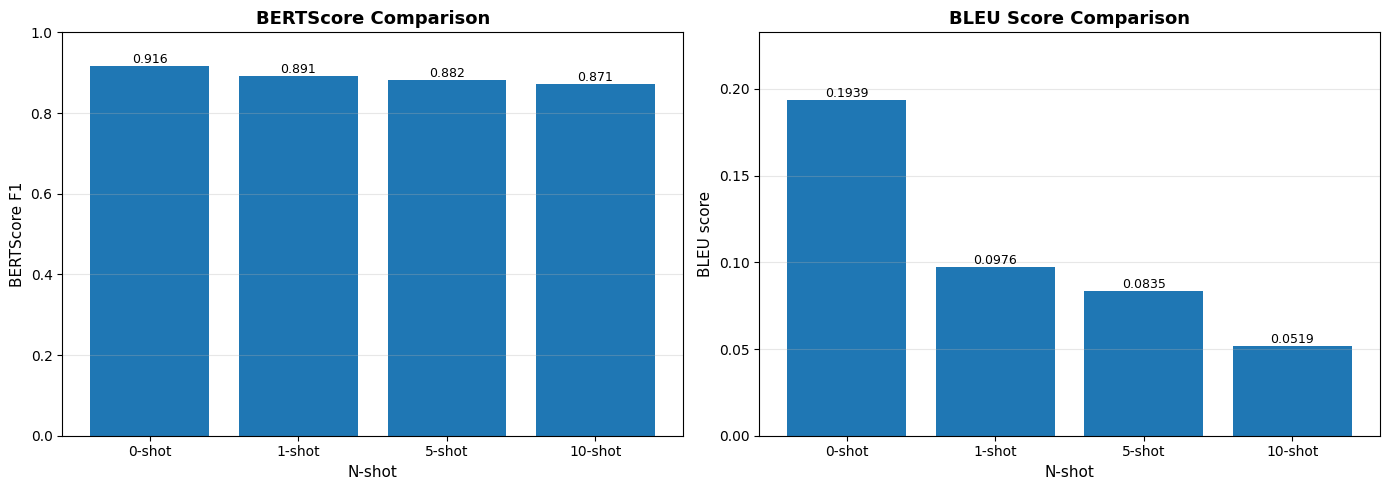

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(len(results_df))
labels = results_df['n_shots'].astype(int)

# BERTScore
bertscores = results_df['bertscore_f1']
bars1 = axes[0].bar(x, bertscores)

axes[0].set_xlabel('N-shot', fontsize=11)
axes[0].set_ylabel('BERTScore F1', fontsize=11)
axes[0].set_title('BERTScore Comparison', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels([f'{n}-shot' for n in labels])
axes[0].set_ylim([0, 1.0])
axes[0].grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# BLEU
bleu_scores = results_df['bleu']
bars2 = axes[1].bar(x, bleu_scores)

axes[1].set_xlabel('N-shot', fontsize=11)
axes[1].set_ylabel('BLEU score', fontsize=11)
axes[1].set_title('BLEU Score Comparison', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels([f'{n}-shot' for n in labels])
axes[1].set_ylim([0, max(bleu_scores) * 1.2])
axes[1].grid(axis='y', alpha=0.3)

for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [39]:
best_config = results_df.loc[results_df['bertscore_f1'].idxmax()]
print(f"\nBest config: {int(best_config['n_shots'])}-shot")
print(f"BERTScore F1: {best_config['bertscore_f1']:.4f}")
print(f"BLEU: {best_config['bleu']:.4f}")


Best config: 0-shot
BERTScore F1: 0.9156
BLEU: 0.1939


In [40]:
all_results = {
    # Lab 3- Multi-task Learning
    'T5 (Lab3)': {
        'bleu': 0.0152,
        'bertscore_f1': 0.6203
    },
    'FLAN-T5 (Lab3)': {
        'bleu': 0.1948,
        'bertscore_f1': 0.7568
    },
    'T5 (Instructional FT) (Lab3)': {
        'bleu': 0.2240,
        'bertscore_f1': 0.7625
    },
    'T5 Multi-task (Lab3)': {
        'bleu': 0.1759,
        'bertscore_f1': 0.7423
    },

    # Lab 4- Few-shot Learning
    'LLaMA-2 0-shot (Lab4)': {
        'bleu': results[0]['bleu'],
        'bertscore_f1': results[0]['bertscore_f1']
    },
    'LLaMA-2 1-shot (Lab4)': {
        'bleu': results[1]['bleu'],
        'bertscore_f1': results[1]['bertscore_f1']
    },
    'LLaMA-2 5-shot (Lab4)': {
        'bleu': results[2]['bleu'],
        'bertscore_f1': results[2]['bertscore_f1']
    },
    'LLaMA-2 10-shot (Lab4)': {
        'bleu': results[3]['bleu'],
        'bertscore_f1': results[3]['bertscore_f1']
    }
}

In [43]:
df = pd.DataFrame([
    {
        'Model': name,
        'BERTScore': row['bertscore_f1'],
        'BLEU': row['bleu'],
    }
    for name, row  in all_results.items()
]).sort_values('BERTScore', ascending=False).reset_index(drop=True)

print(df.to_string(index=False))

                       Model  BERTScore     BLEU
       LLaMA-2 0-shot (Lab4)   0.915629 0.193885
       LLaMA-2 1-shot (Lab4)   0.890668 0.097555
       LLaMA-2 5-shot (Lab4)   0.881919 0.083526
      LLaMA-2 10-shot (Lab4)   0.870858 0.051910
T5 (Instructional FT) (Lab3)   0.762500 0.224000
              FLAN-T5 (Lab3)   0.756800 0.194800
        T5 Multi-task (Lab3)   0.742300 0.175900
                   T5 (Lab3)   0.620300 0.015200


##### Conclusion

The instruction-fine-tuned T5 models from the previous laboratory exercise achieve the highest BLEU scores, indicating better lexical overlap with the reference sentences due to direct supervised training. LLaMA-2 achieves higher BERTScore values, especially in the 0-shot configuration, showing strong semantic similarity despite the absence of task-specific training. As the number of few-shot examples increases, both BLEU and BERTScore decrease, suggesting prompt saturation and reduced generalization.